### 1. IMPORT LIBRARIES AND CIFAR 10, PREPARE DATA

In [29]:
# general
import numpy as np
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import keras
import time
import matplotlib.pyplot as plt
% matplotlib inline

# dataset
from keras.datasets import cifar10

# modeling tools
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD, RMSprop, Adam, Adadelta, Adagrad
from keras.utils.np_utils import to_categorical

Check and Prepare Data:

In [30]:
# split data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# check data dimension
print('training data shape: {}'.format(x_train.shape))
print('test data shape: {}'.format(x_test.shape))

training data shape: (50000, 32, 32, 3)
test data shape: (10000, 32, 32, 3)


In [31]:
# check labels
labels = []
for y in y_train.flatten():
    if y not in labels:
        labels.append(y)
print('training labels are: {}'.format(labels))
print('# labels: {}'.format(len(labels)))

training labels are: [6, 9, 4, 1, 2, 7, 8, 3, 5, 0]
# labels: 10


In [32]:
# Convert class vectors to one-hot encoded vectors.
y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

In [33]:
# Transform images from (32,32,3) to 3072-dimensional vectors (32*32*3)

x_train = np.reshape(x_train,(50000,3072))
x_test = np.reshape(x_test,(10000,3072))
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalization of pixel values (to [0-1] range)

x_train /= 255
x_test /= 255

### 2. HELP FUNCTION

In [52]:
def plotAcc(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model_accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc = 'lower right')
    
def plotLoss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model_loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc = 'upper right')

In [53]:
# get the best accuracy result

def getBest(record):
    max_acc = 0
    experiment = None
    for value in record.values():
        max_acc = max(max_acc, value[1])

    for key in record.keys():
        if record[key][1] == max_acc:
              experiment = key

    return max_acc, experiment, record[key][3]

In [54]:
# get the summary of all experiments

import pandas as pd

def get_allResult(record):
    df_result = pd.DataFrame()
    length = len(list(record.keys()))
    df_result['Experiment'] = list(record.keys())
    df_result['Loss'] = [list(record.values())[i][0] for i in range(length)]
    df_result['Accuracy'] = [list(record.values())[i][1] for i in range(length)]
    return df_result

### 3. EXPERIMENTS - TEST WITH #NEURON, #LAYERS, %DROPOUT

#### 1. Set up hyperparameters for different configuration

In [35]:
# historic configuration: will be exluded in this test
# dropout_rate = 0.2
# number_of_layer = 3
# number_of_neuron = 256
# configuration = [256,256]

list_layer = [[64], [128], [256], [512], [1024],  \
        [64,64], [128,128], [512,512], [1024,1024], \
        [64,64,64], [128,128,128], [256,256,256], [512,512,512], [1024,1024,1024]]

list_dropout_rate = [0.2,0.4,0.6]

list_config = []
for n_neuron in list_layer:
    for dropout_rate in list_dropout_rate:
        list_config.append([n_neuron, dropout_rate])
        
print(list_config[:5])
print(len(list_config))

[[[64], 0.2], [[64], 0.4], [[64], 0.6], [[128], 0.2], [[128], 0.4]]
42


#### 2. Control other conditions and hyperparameters

In [36]:
# set conditions
n_class = 10
input_dimension = 32*32*3

# hyper parameters
batch_size = 128
epochs = 20

# use the best combo of optimizer and lr from optimizer experiment
optimizer = keras.optimizers.Adam(lr = 0.0001)

# use the best activation function from activation experiment
activation = 'relu'

# record hyper parameter information in dictionary                 
param_dict = {
        'batch_size': 128,
        'epochs': 20,
        'optimizer': 'Adam with 0.0001 lr',
        'activation': 'relu'
    }

#### 3. Set up experiment function

In [40]:
def experiment_config(list_config):
    
    record = {}            
    model = Sequential()
    for i, config in enumerate(list_config):   
        layer = config[0]
        dropout_rate = config[1]
        for j, n_neuron in enumerate(layer):

            if j == 0:
                model.add(Dense(n_neuron, activation = activation, input_dim = input_dimension))
                model.add(Dropout(dropout_rate))
            else:
                model.add(Dense(n_neuron, activation = activation))
                model.add(Dropout(dropout_rate))

        model.add(Dense(n_class, activation = 'softmax'))

        model.compile(optimizer = optimizer,
                      loss = 'categorical_crossentropy',
                      metrics = ['accuracy'])

        start = time.clock()
        exp_config = model.fit(x_train, 
                               y_train, 
                               epochs = epochs, 
                               batch_size = batch_size,
                               verbose = 2,
                               validation_data = (x_test, y_test))
        elapsed = (time.clock() - start)
        scores = model.evaluate(x_test, y_test, verbose=1)

        # record experiment information:
        record['layers and dropout_rates are: ' + str(list_config[i])] = [scores[0], scores[1], elapsed, exp_config]

        # print experiment name:
        print('*******************************************************')
        print('=======================================================')
        print('Experiment' + str(i) + ':'  + '\t' + 'layers and dropout_rates are: ' + str(list_config[i]))
        print('=======================================================')
        # print all used parameters for this model
#         for i,j in param_dict.items():
#             print(str(i) + '\t' + str(j)) 
#             print('-------------------------------------------------------')

        # print running time used
        print('Time Used: {}'.format(elapsed))
        print('-------------------------------------------------------')

        # print best loss and accuracy result
        print('Test loss:', scores[0])
        print('-------------------------------------------------------')
        print('Test accuracy:', scores[1])

        print('*******************************************************')

    return record

#### 4. Experiment

In [41]:
record = experiment_config(list_config)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
 - 3s - loss: 2.0558 - acc: 0.2365 - val_loss: 1.9109 - val_acc: 0.3252
Epoch 2/20
 - 2s - loss: 1.9382 - acc: 0.2964 - val_loss: 1.8601 - val_acc: 0.3542
Epoch 3/20
 - 2s - loss: 1.8945 - acc: 0.3149 - val_loss: 1.8170 - val_acc: 0.3642
Epoch 4/20
 - 2s - loss: 1.8639 - acc: 0.3290 - val_loss: 1.7979 - val_acc: 0.3740
Epoch 5/20
 - 2s - loss: 1.8450 - acc: 0.3371 - val_loss: 1.7756 - val_acc: 0.3878
Epoch 6/20
 - 2s - loss: 1.8271 - acc: 0.3448 - val_loss: 1.7561 - val_acc: 0.3873
Epoch 7/20
 - 2s - loss: 1.8172 - acc: 0.3539 - val_loss: 1.7385 - val_acc: 0.3985
Epoch 8/20
 - 2s - loss: 1.8053 - acc: 0.3527 - val_loss: 1.7307 - val_acc: 0.3977
Epoch 9/20
 - 2s - loss: 1.7962 - acc: 0.3587 - val_loss: 1.7232 - val_acc: 0.4018
Epoch 10/20
 - 2s - loss: 1.7861 - acc: 0.3646 - val_loss: 1.7141 - val_acc: 0.4100
Epoch 11/20
 - 3s - loss: 1.7778 - acc: 0.3647 - val_loss: 1.7004 - val_acc: 0.4105
Epoch 12/20
 - 2s - loss: 1.7674 - 

Epoch 18/20
 - 2s - loss: 1.8523 - acc: 0.2894 - val_loss: 1.8173 - val_acc: 0.3118
Epoch 19/20
 - 2s - loss: 1.8575 - acc: 0.2871 - val_loss: 1.8121 - val_acc: 0.3102
Epoch 20/20
 - 2s - loss: 1.8541 - acc: 0.2901 - val_loss: 1.8105 - val_acc: 0.3071
10000/10000 [==============================] - 0s 32us/step
*******************************************************
Experiment3:	layers and dropout_rates are: [[128], 0.2]
Time Used: 124.401253
-------------------------------------------------------
Test loss: 1.8104729793548584
-------------------------------------------------------
Test accuracy: 0.3071
*******************************************************
Train on 50000 samples, validate on 10000 samples
Epoch 1/20
 - 4s - loss: 2.1262 - acc: 0.1727 - val_loss: 2.0253 - val_acc: 0.2103
Epoch 2/20
 - 3s - loss: 2.0098 - acc: 0.2092 - val_loss: 1.9566 - val_acc: 0.2652
Epoch 3/20
 - 3s - loss: 1.9595 - acc: 0.2483 - val_loss: 1.9014 - val_acc: 0.2728
Epoch 4/20
 - 3s - loss: 1.9238 - a

Epoch 9/20
 - 4s - loss: 1.8584 - acc: 0.2735 - val_loss: 1.8294 - val_acc: 0.2882
Epoch 10/20
 - 4s - loss: 1.8509 - acc: 0.2753 - val_loss: 1.8265 - val_acc: 0.2897
Epoch 11/20
 - 4s - loss: 1.8471 - acc: 0.2772 - val_loss: 1.8183 - val_acc: 0.2992
Epoch 12/20
 - 4s - loss: 1.8442 - acc: 0.2794 - val_loss: 1.8144 - val_acc: 0.2990
Epoch 13/20
 - 4s - loss: 1.8438 - acc: 0.2823 - val_loss: 1.8200 - val_acc: 0.2961
Epoch 14/20
 - 4s - loss: 1.8388 - acc: 0.2811 - val_loss: 1.8187 - val_acc: 0.2962
Epoch 15/20
 - 4s - loss: 1.8381 - acc: 0.2841 - val_loss: 1.8129 - val_acc: 0.3049
Epoch 16/20
 - 4s - loss: 1.8343 - acc: 0.2863 - val_loss: 1.8102 - val_acc: 0.2991
Epoch 17/20
 - 4s - loss: 1.8384 - acc: 0.2837 - val_loss: 1.8130 - val_acc: 0.2999
Epoch 18/20
 - 4s - loss: 1.8390 - acc: 0.2827 - val_loss: 1.8133 - val_acc: 0.2998
Epoch 19/20
 - 4s - loss: 1.8345 - acc: 0.2859 - val_loss: 1.8061 - val_acc: 0.3048
Epoch 20/20
 - 4s - loss: 1.8335 - acc: 0.2836 - val_loss: 1.8054 - val_acc: 

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
 - 10s - loss: 2.0217 - acc: 0.2446 - val_loss: 1.8643 - val_acc: 0.2814
Epoch 2/20
 - 7s - loss: 1.8650 - acc: 0.2758 - val_loss: 1.8412 - val_acc: 0.2883
Epoch 3/20
 - 7s - loss: 1.8442 - acc: 0.2840 - val_loss: 1.8319 - val_acc: 0.2940
Epoch 4/20
 - 7s - loss: 1.8349 - acc: 0.2859 - val_loss: 1.8283 - val_acc: 0.2946
Epoch 5/20
 - 7s - loss: 1.8285 - acc: 0.2869 - val_loss: 1.8241 - val_acc: 0.2944
Epoch 6/20
 - 7s - loss: 1.8253 - acc: 0.2901 - val_loss: 1.8203 - val_acc: 0.2952
Epoch 7/20
 - 7s - loss: 1.8263 - acc: 0.2886 - val_loss: 1.8171 - val_acc: 0.2961
Epoch 8/20
 - 7s - loss: 1.8283 - acc: 0.2895 - val_loss: 1.8161 - val_acc: 0.2950
Epoch 9/20
 - 7s - loss: 1.8219 - acc: 0.2927 - val_loss: 1.8145 - val_acc: 0.2975
Epoch 10/20
 - 7s - loss: 1.8220 - acc: 0.2925 - val_loss: 1.8242 - val_acc: 0.2943
Epoch 11/20
 - 7s - loss: 1.8194 - acc: 0.2944 - val_loss: 1.8177 - val_acc: 0.2979
Epoch 12/20
 - 6s - loss: 1.8188 -

Epoch 18/20
 - 10s - loss: 1.7978 - acc: 0.3052 - val_loss: 1.8000 - val_acc: 0.3193
Epoch 19/20
 - 10s - loss: 1.7999 - acc: 0.3071 - val_loss: 1.8078 - val_acc: 0.3067
Epoch 20/20
 - 10s - loss: 1.7937 - acc: 0.3090 - val_loss: 1.7942 - val_acc: 0.3170
10000/10000 [==============================] - 1s 95us/step
*******************************************************
Experiment14:	layers and dropout_rates are: [[1024], 0.6]
Time Used: 535.0850809999997
-------------------------------------------------------
Test loss: 1.7942081130981444
-------------------------------------------------------
Test accuracy: 0.317
*******************************************************
Train on 50000 samples, validate on 10000 samples
Epoch 1/20
 - 15s - loss: 2.1103 - acc: 0.2077 - val_loss: 1.9356 - val_acc: 0.2444
Epoch 2/20
 - 11s - loss: 1.9223 - acc: 0.2362 - val_loss: 1.8961 - val_acc: 0.2507
Epoch 3/20
 - 11s - loss: 1.9059 - acc: 0.2396 - val_loss: 1.8716 - val_acc: 0.2540
Epoch 4/20
 - 10s - l

Epoch 8/20
 - 11s - loss: 2.0087 - acc: 0.1886 - val_loss: 1.9981 - val_acc: 0.1966
Epoch 9/20
 - 11s - loss: 2.0076 - acc: 0.1891 - val_loss: 1.9873 - val_acc: 0.1938
Epoch 10/20
 - 12s - loss: 1.9956 - acc: 0.1908 - val_loss: 1.9878 - val_acc: 0.1997
Epoch 11/20
 - 12s - loss: 1.9905 - acc: 0.1955 - val_loss: 1.9971 - val_acc: 0.1983
Epoch 12/20
 - 12s - loss: 2.0091 - acc: 0.1944 - val_loss: 2.0154 - val_acc: 0.2087
Epoch 13/20
 - 12s - loss: 2.0240 - acc: 0.1899 - val_loss: 1.9875 - val_acc: 0.2003
Epoch 14/20
 - 12s - loss: 2.0087 - acc: 0.1967 - val_loss: 1.9848 - val_acc: 0.1975
Epoch 15/20
 - 12s - loss: 1.9950 - acc: 0.2032 - val_loss: 1.9831 - val_acc: 0.2029
Epoch 16/20
 - 12s - loss: 1.9867 - acc: 0.2085 - val_loss: 1.9779 - val_acc: 0.2064
Epoch 17/20
 - 13s - loss: 1.9820 - acc: 0.2106 - val_loss: 1.9725 - val_acc: 0.2095
Epoch 18/20
 - 12s - loss: 1.9881 - acc: 0.2087 - val_loss: 1.9589 - val_acc: 0.2137
Epoch 19/20
 - 11s - loss: 1.9676 - acc: 0.2108 - val_loss: 1.9589 

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
 - 30s - loss: 2.1947 - acc: 0.1499 - val_loss: 2.2316 - val_acc: 0.1517
Epoch 2/20
 - 19s - loss: 2.2274 - acc: 0.1403 - val_loss: 2.2525 - val_acc: 0.1296
Epoch 3/20
 - 19s - loss: 2.2057 - acc: 0.1456 - val_loss: 2.1852 - val_acc: 0.1548
Epoch 4/20
 - 19s - loss: 2.1735 - acc: 0.1532 - val_loss: 2.1789 - val_acc: 0.1409
Epoch 5/20
 - 19s - loss: 2.1625 - acc: 0.1476 - val_loss: 2.1502 - val_acc: 0.1506
Epoch 6/20
 - 19s - loss: 2.1498 - acc: 0.1499 - val_loss: 2.0944 - val_acc: 0.1678
Epoch 7/20
 - 20s - loss: 2.1386 - acc: 0.1567 - val_loss: 2.1237 - val_acc: 0.1577
Epoch 8/20
 - 19s - loss: 2.1125 - acc: 0.1633 - val_loss: 2.0732 - val_acc: 0.1751
Epoch 9/20
 - 19s - loss: 2.1473 - acc: 0.1595 - val_loss: 2.2444 - val_acc: 0.1372
Epoch 10/20
 - 19s - loss: 2.2308 - acc: 0.1416 - val_loss: 2.1619 - val_acc: 0.1670
Epoch 11/20
 - 19s - loss: 2.2001 - acc: 0.1530 - val_loss: 2.1050 - val_acc: 0.1846
Epoch 12/20
 - 19s - los

Epoch 17/20
 - 43s - loss: 2.1983 - acc: 0.1414 - val_loss: 2.1263 - val_acc: 0.1651
Epoch 18/20
 - 43s - loss: 2.2011 - acc: 0.1404 - val_loss: 2.1940 - val_acc: 0.1445
Epoch 19/20
 - 43s - loss: 2.2007 - acc: 0.1418 - val_loss: 2.1879 - val_acc: 0.1446
Epoch 20/20
 - 43s - loss: 2.2113 - acc: 0.1364 - val_loss: 2.2854 - val_acc: 0.1086
10000/10000 [==============================] - 4s 379us/step
*******************************************************
Experiment25:	layers and dropout_rates are: [[1024, 1024], 0.4]
Time Used: 2719.049793
-------------------------------------------------------
Test loss: 2.285413084411621
-------------------------------------------------------
Test accuracy: 0.1086
*******************************************************
Train on 50000 samples, validate on 10000 samples
Epoch 1/20
 - 68s - loss: 2.2019 - acc: 0.1490 - val_loss: 2.1321 - val_acc: 0.1653
Epoch 2/20
 - 53s - loss: 2.1639 - acc: 0.1586 - val_loss: 2.1143 - val_acc: 0.1727
Epoch 3/20
 - 53s -

Epoch 6/20
 - 55s - loss: 2.2744 - acc: 0.1154 - val_loss: 2.2691 - val_acc: 0.1148
Epoch 7/20
 - 55s - loss: 2.2659 - acc: 0.1198 - val_loss: 2.2678 - val_acc: 0.1149
Epoch 8/20
 - 56s - loss: 2.2668 - acc: 0.1193 - val_loss: 2.2682 - val_acc: 0.1149
Epoch 9/20
 - 54s - loss: 2.2546 - acc: 0.1214 - val_loss: 2.1903 - val_acc: 0.1522
Epoch 10/20
 - 55s - loss: 2.2207 - acc: 0.1530 - val_loss: 2.1909 - val_acc: 0.1697
Epoch 11/20
 - 55s - loss: 2.2049 - acc: 0.1568 - val_loss: 2.1801 - val_acc: 0.1697
Epoch 12/20
 - 55s - loss: 2.1975 - acc: 0.1532 - val_loss: 2.1710 - val_acc: 0.1697
Epoch 13/20
 - 55s - loss: 2.1913 - acc: 0.1565 - val_loss: 2.1678 - val_acc: 0.1698
Epoch 14/20
 - 54s - loss: 2.1859 - acc: 0.1597 - val_loss: 2.1612 - val_acc: 0.1697
Epoch 15/20
 - 55s - loss: 2.1855 - acc: 0.1556 - val_loss: 2.1560 - val_acc: 0.1706
Epoch 16/20
 - 55s - loss: 2.1808 - acc: 0.1578 - val_loss: 2.1570 - val_acc: 0.1706
Epoch 17/20
 - 55s - loss: 2.1818 - acc: 0.1553 - val_loss: 2.1572 - 

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
 - 94s - loss: 2.1696 - acc: 0.1586 - val_loss: 2.1271 - val_acc: 0.1699
Epoch 2/20
 - 65s - loss: 2.1597 - acc: 0.1595 - val_loss: 2.1254 - val_acc: 0.1699
Epoch 3/20
 - 64s - loss: 2.1582 - acc: 0.1611 - val_loss: 2.1268 - val_acc: 0.1699
Epoch 4/20
 - 64s - loss: 2.1604 - acc: 0.1599 - val_loss: 2.1261 - val_acc: 0.1708
Epoch 5/20
 - 65s - loss: 2.1632 - acc: 0.1595 - val_loss: 2.1272 - val_acc: 0.1708
Epoch 6/20
 - 64s - loss: 2.1604 - acc: 0.1602 - val_loss: 2.1267 - val_acc: 0.1699
Epoch 7/20
 - 64s - loss: 2.1598 - acc: 0.1594 - val_loss: 2.1282 - val_acc: 0.1699
Epoch 8/20
 - 65s - loss: 2.1582 - acc: 0.1617 - val_loss: 2.1254 - val_acc: 0.1708
Epoch 9/20
 - 64s - loss: 2.1607 - acc: 0.1597 - val_loss: 2.1287 - val_acc: 0.1699
Epoch 10/20
 - 66s - loss: 2.1581 - acc: 0.1636 - val_loss: 2.1264 - val_acc: 0.1708
Epoch 11/20
 - 78s - loss: 2.1598 - acc: 0.1609 - val_loss: 2.1272 - val_acc: 0.1708
Epoch 12/20
 - 67s - los

Epoch 17/20
 - 72s - loss: 2.1578 - acc: 0.1616 - val_loss: 2.1270 - val_acc: 0.1699
Epoch 18/20
 - 71s - loss: 2.1581 - acc: 0.1637 - val_loss: 2.1266 - val_acc: 0.1708
Epoch 19/20
 - 79s - loss: 2.1556 - acc: 0.1608 - val_loss: 2.1302 - val_acc: 0.1699
Epoch 20/20
 - 83s - loss: 2.1568 - acc: 0.1613 - val_loss: 2.1270 - val_acc: 0.1708
10000/10000 [==============================] - 9s 905us/step
*******************************************************
Experiment36:	layers and dropout_rates are: [[512, 512, 512], 0.2]
Time Used: 4461.7858019999985
-------------------------------------------------------
Test loss: 2.1270097160339354
-------------------------------------------------------
Test accuracy: 0.1708
*******************************************************
Train on 50000 samples, validate on 10000 samples
Epoch 1/20
 - 144s - loss: 2.1717 - acc: 0.1561 - val_loss: 2.1299 - val_acc: 0.1708
Epoch 2/20
 - 97s - loss: 2.1629 - acc: 0.1582 - val_loss: 2.1288 - val_acc: 0.1708
Epoch 3

Epoch 6/20
 - 174s - loss: 2.1589 - acc: 0.1601 - val_loss: 2.1273 - val_acc: 0.1699
Epoch 7/20
 - 132s - loss: 2.1554 - acc: 0.1606 - val_loss: 2.1262 - val_acc: 0.1708
Epoch 8/20
 - 151s - loss: 2.1587 - acc: 0.1610 - val_loss: 2.1278 - val_acc: 0.1708
Epoch 9/20
 - 151s - loss: 2.1570 - acc: 0.1603 - val_loss: 2.1258 - val_acc: 0.1699
Epoch 10/20
 - 141s - loss: 2.1601 - acc: 0.1593 - val_loss: 2.1298 - val_acc: 0.1699
Epoch 11/20
 - 149s - loss: 2.1575 - acc: 0.1618 - val_loss: 2.1262 - val_acc: 0.1699
Epoch 12/20
 - 138s - loss: 2.1585 - acc: 0.1618 - val_loss: 2.1273 - val_acc: 0.1708
Epoch 13/20
 - 162s - loss: 2.1616 - acc: 0.1597 - val_loss: 2.1263 - val_acc: 0.1708
Epoch 14/20
 - 148s - loss: 2.1591 - acc: 0.1618 - val_loss: 2.1261 - val_acc: 0.1699
Epoch 15/20
 - 148s - loss: 2.1585 - acc: 0.1630 - val_loss: 2.1291 - val_acc: 0.1682
Epoch 16/20
 - 149s - loss: 2.1588 - acc: 0.1614 - val_loss: 2.1292 - val_acc: 0.1642
Epoch 17/20
 - 131s - loss: 2.1574 - acc: 0.1631 - val_los

### 4. SUMMARIZE EXPERIMENTS

#### 1. Best result

In [55]:
max_acc, experiment, history = getBest(record)
print('The Best Result is:')
max_acc, experiment

The Best Result is:


(0.4313, 'layers and dropout_rates are: [[64], 0.2]')

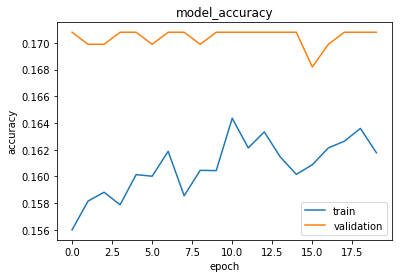

In [56]:
plotAcc(history)

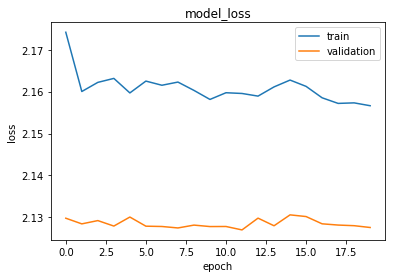

In [57]:
plotLoss(history)

#### 2. Result summary

In [64]:
df_result = get_allResult(record)

# add control parameters

df_result['activation'] = 'relu'
df_result['optimizer'] = 'Adam with learning rate @ 0.001'
df_result['batch_size'] = 128

# df_result['num_layers'] = 3
# df_result['num_neurons'] = 256
# df_result['dropout_rate'] = 0.2

In [65]:
df_result.rename(columns = {"Experiment": "Config"}, inplace = True)
df_result.sort_values(by = 'Accuracy', axis = 0, ascending = False)

,Config,Loss,Accuracy,activation,optimizer,batch_size
0,"layers and dropout_rates are: [[64], 0.2]",1.644154,0.4313,relu,Adam with learning rate @ 0.001,128
14,"layers and dropout_rates are: [[1024], 0.6]",1.794208,0.3170,relu,Adam with learning rate @ 0.001,128
13,"layers and dropout_rates are: [[1024], 0.4]",1.798803,0.3143,relu,Adam with learning rate @ 0.001,128
4,"layers and dropout_rates are: [[128], 0.4]",1.804887,0.3140,relu,Adam with learning rate @ 0.001,128
12,"layers and dropout_rates are: [[1024], 0.2]",1.798460,0.3126,relu,Adam with learning rate @ 0.001,128
15,"layers and dropout_rates are: [[64, 64], 0.2]",1.803888,0.3125,relu,Adam with learning rate @ 0.001,128
10,"layers and dropout_rates are: [[512], 0.4]",1.813594,0.3117,relu,Adam with learning rate @ 0.001,128
9,"layers and dropout_rates are: [[512], 0.2]",1.820373,0.3078,relu,Adam with learning rate @ 0.001,128
3,"layers and dropout_rates are: [[128], 0.2]",1.810473,0.3071,relu,Adam with learning rate @ 0.001,128
6,"layers and dropout_rates are: [[256], 0.2]",1.805768,0.3063,relu,Adam with learning rate @ 0.001,128


In [67]:
df_result.to_csv('exe_config.csv')